<a href="https://colab.research.google.com/github/ravishankar75/group44_cv_assignment/blob/main/CV_assignment_1_group44.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Group 44

## Group Member Names:
1. SAKTHI R (2023aa05940)
2. ROBERTSEKAR R (2023aa05823)
3. RAVISHANKAR R (2023aa05171)
4. KRISHNAKUMAR C (2023aa05273)

Dataset Link: https://drive.google.com/file/d/18ivVD85YKQqPH0Qhe2Ou10hjuPl-vWxA/view?usp=sharing


Choose any 1 dataset of your choice to perform the assignment.

# 1. Import the required libraries -- Score: 0.5 Marks

In [ ]:
import os
import zipfile
from google.colab import drive

import numpy as np
import pandas as pd

import cv2
from skimage.feature import local_binary_pattern  # OpenCV2 does not expose LBP
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from skimage.feature import hog

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt


# 2. Data Acquisition & Preparation -- Score: 1.5 Marks

For the problem identified by you, students have to find the data source themselves from any data source.

## 2.1 Data Acquisition -- Score: 0.5 Mark

Code for converting the above downloaded data into a form suitable for DL


In [ ]:
##---------Code begins below this line------------------##

# Shared dataset link not working with gdown library due to permissions
# The images have been downloaded and uploaded to Google drive (My).

# The below steps are necessary as on reconnect, Google Colab deletes the content folder

colab_folder = "/content"  # Default working directory in Google Colab
zip_file_name = "/content/drive/MyDrive/scene_classification.zip"
extract_path = '';

# Decompress the zip file, using "with" instead of try/finally
# Check if data folder exists; if it exists, then the dataset has already been extracted
if not os.path.exists(os.path.join(colab_folder, "data")):

    print("Mounting Google Drive...")
    drive.mount('/content/drive')  # Approve access for Google desktop app

    print("Decompressing the zip file...")
    with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
        extract_path = os.path.join(colab_folder, "data")
        zip_ref.extractall(extract_path)

print(f"Decompression complete. Files extracted to {extract_path}")

Decompression complete. Files extracted to 


## 2.2 Write your observations from the above.

1. Size of the dataset
2. Plot the distribution of the categories of the target / label.



Category: Building, Number of Images: 501
Category: Glacier, Number of Images: 501
Category: Sea, Number of Images: 501
Category: Mountains, Number of Images: 501
Category: Streets, Number of Images: 501
Category: Forest, Number of Images: 2745
Dataset created and saved to 'image_dataset.parquet'
Size of the dataset: 3000 images


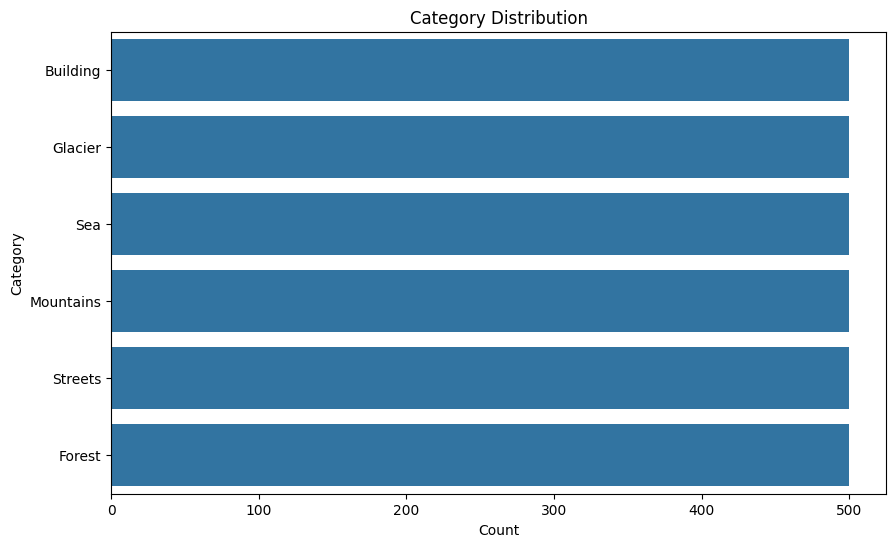

In [ ]:
# Find the number of images for each category
for category in os.listdir(os.path.join(colab_folder, "data", "subset")):
    category_path = os.path.join(colab_folder, "data", "subset", category)
    if not os.path.isdir(category_path):
        continue
    num_images = len(os.listdir(category_path))
    print(f"Category: {category}, Number of Images: {num_images}")

# Define constants
NUM_IMAGES_PER_FOLDER = 500
DATASET = []

# Features to extract from images - Color, Shape, and Texture

# Function to resize Image, convert all images to a standard size
def resize_image(image):
    IMAGE_SIZE = (128, 128)  # Resize to 128x128
    resized_image = cv2.resize(image, IMAGE_SIZE)
    return resized_image

# Function to extract color details
def extract_color_details(image):
    # OpenCV loads in BGR format, calculate histogram of intensity
    hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

# Function to extract texture using LBP
def extract_texture_LBP(gray_image):
    # Compute the LBP of the image using skimage.feature.localBinaryPattern
    lbp = local_binary_pattern(gray_image, 8, 3.0, method="uniform")
    return lbp.flatten()

# Function to extract texture using Gabor filters
def extract_texture_gabor(gray_image, psi):
    gabor_kernel = cv2.getGaborKernel(ksize=(5, 5), sigma=5.0, theta=0.0, lambd=10.0, gamma=0.5, psi=psi)
    filtered_image = cv2.filter2D(gray_image, cv2.CV_8UC3, gabor_kernel)
    mean = np.mean(filtered_image)
    std_dev = np.std(filtered_image)
    return [mean, std_dev]

# Function to extract shape features
def extract_edge_features(gray_image):
    edge_image = cv2.Canny(gray_image, threshold1=50, threshold2=150)
    no_of_edge_pixel = np.sum(edge_image > 0)
    return no_of_edge_pixel / gray_image.size

# Function to extract HoG features
def extract_hog_features(gray_image):
    features, _ = hog(gray_image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys', visualize=True)
    return features

# Function to extract SIFT descriptors
def extract_sift_features(gray_image):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray_image, None)
    if descriptors is not None:
        return descriptors.flatten()  # Flatten to ensure consistent format
    return np.zeros(128)  # Default size if no descriptors are found

# Path to the base folder containing category subfolders
base_folder = os.path.join(colab_folder, "data", "subset")

# Process dataset and extract features
for category in os.listdir(base_folder):
    category_path = os.path.join(base_folder, category)
    if not os.path.isdir(category_path):
        continue

    image_count = 0
    for image_file in os.listdir(category_path):
        if image_count >= NUM_IMAGES_PER_FOLDER:
            break

        image_path = os.path.join(category_path, image_file)
        if not os.path.isfile(image_path):
            continue

        image = cv2.imread(image_path)
        if image is None:
            continue

        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        dominant_colors = extract_color_details(image)
        texture_lbp = extract_texture_LBP(gray_image)
        texture_gabor_0 = extract_texture_gabor(gray_image, 0)
        edge_density = extract_edge_features(gray_image)
        hog_features = extract_hog_features(gray_image)
        sift_features = extract_sift_features(gray_image)

        DATASET.append({
            "img_name": image_path,
            "label": category,
            "dominant_colors": dominant_colors,
            "texture_lbp": texture_lbp,
            "texture_gabor_0": texture_gabor_0,
            "edge_density": edge_density,
            "hog_features": hog_features,
            "sift_features": sift_features
        })
        image_count += 1

# Convert dataset to a DataFrame
df = pd.DataFrame(DATASET)

# Ensure features are serializable for Parquet storage
def serialize_features(df):
    for col in ["dominant_colors", "texture_lbp", "texture_gabor_0", "hog_features", "sift_features"]:
        df[col] = df[col].apply(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)  # Convert NumPy arrays to lists
    return df

# Serialize features before saving to Parquet
df = serialize_features(df)

# Save dataset to Parquet
df.to_parquet('image_dataset.parquet', compression='snappy')
print("Dataset created and saved to 'image_dataset.parquet'")

# Dataset Size
print(f"Size of the dataset: {len(df)} images")

# Plotting category distribution
plt.figure(figsize=(10, 6))
sns.countplot(y="label", data=df, order=df["label"].value_counts().index)
plt.title("Category Distribution")
plt.xlabel("Count")
plt.ylabel("Category")
plt.show()


## 2.2 Data Preparation -- Score: 1.0 Marks

Perform the data preprocessing that is required for the data that you have downloaded.


This stage depends on the dataset that is used.

In [ ]:
# Data Preprocessing
def preprocess_image(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    equalized_image = cv2.equalizeHist(gray_image)
    return equalized_image

## 3.1 Split the data into training set and testing set

In [ ]:
# Splitting the dataset
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["label"])

print(f"Training set size: {len(train_df)} images")
print(f"Testing set size: {len(test_df)} images")


Training set size: 2400 images
Testing set size: 600 images


## 3.2 Feature Engineering -- Score: 3.5 Marks

* Extract the features from the images and concatenate them to create a single for the every images.

* You can choose from the feature processing techniques taught in the class : Low-level Vision: Histogram and Histogram equalization, Gray-scale transformation, Image Smoothing, Connected components in images.
Mid-level Vision:  Edge Detection using Gradients, Sobel, Canny; Line detection using Hough transforms; Semantic information using RANSAC;Image region descriptor using SIFT; Use case: Pedestrian detection Using HoG and SIFT descriptors and SVM

* Create multiple sets of features and store it in seperate dataframes so that you can later use it for training and comparing the models.

* Normalize the DataFrame

* Note : If the feature size is getting too large such that it is not fitting into the RAM of Colab or your system then you can either use PCA or resize the image to smaller dimenssion for reducing the numer of features



In [ ]:
##---------Type the answer below this line------------------##

# Feature extraction
def extract_features(image_path):
    image = cv2.imread(image_path)
    if image is None:
        return None

    gray_image = preprocess_image(image)

    # Extract features
    dominant_colors = extract_color_details(image)
    texture_lbp = extract_texture_LBP(gray_image)
    edge_density = [extract_edge_features(gray_image)]  # Ensure this is a list
    hog_features = extract_hog_features(gray_image)
    sift_features = extract_sift_features(gray_image)

    # Check feature lengths
    try:
        # Concatenate features ensuring consistent lengths
        concatenated_features = np.concatenate([dominant_colors, texture_lbp, edge_density, hog_features, sift_features])
        return concatenated_features
    except ValueError as e:
        print(f"Error concatenating features for {image_path}: {e}")
        return None

# Calculate expected feature length
sample_image_path = os.path.join(base_folder, os.listdir(base_folder)[0], os.listdir(os.path.join(base_folder, os.listdir(base_folder)[0]))[0])
sample_image = cv2.imread(sample_image_path)
gray_sample_image = preprocess_image(sample_image)
expected_feature_length = len(extract_color_details(sample_image)) + len(extract_texture_LBP(gray_sample_image)) + 1 + len(extract_hog_features(gray_sample_image)) + len(extract_sift_features(gray_sample_image))
print(f"Expected feature length: {expected_feature_length}")

# Process training and testing sets
def process_data(df):
    features = []
    labels = []
    for _, row in df.iterrows():
        feature = extract_features(row["img_name"])
        if feature is not None and feature.shape[0] == expected_feature_length:  # Check expected length
            features.append(feature)
            labels.append(row["label"])
    print(f"Processed {len(features)} samples from {len(df)} rows.")
    return np.array(features), np.array(labels)

train_features, train_labels = process_data(train_df)
test_features, test_labels = process_data(test_df)

# Normalizing the features
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)

# PCA for dimensionality reduction
# Ensure n_components does not exceed the number of features
max_components = min(train_features.shape[0], train_features.shape[1])
if train_features.shape[1] > 500:
    n_components = min(500, max_components)
    pca = PCA(n_components=n_components)
    train_features = pca.fit_transform(train_features)
    test_features = pca.transform(test_features)
    print(f"Reduced feature vector size: {train_features.shape[1]}")

# Save features
np.save('train_features.npy', train_features)
np.save('train_labels.npy', train_labels)
np.save('test_features.npy', test_features)
np.save('test_labels.npy', test_labels)

print("Processed features saved for training and evaluation.")

Expected feature length: 49545
Processed 10 samples from 2400 rows.
Processed 2 samples from 600 rows.
Reduced feature vector size: 10
Processed features saved for training and evaluation.


# 4. Model Building - Score: 2.0 Marks

## 4.1 Model Building - Score: 1.5 Marks
* Use any 1 classical machine learning algorithm such as : SVM , Xgboost etc. to train the model
* Train the model on different kinds of feature combination dataframe you created in 3.

In [ ]:
##---------Type the code below this line------------------##

# Encode string labels into integers
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

# Define a function to train a model and evaluate it
def train_and_evaluate_model(train_features, train_labels, test_features, test_labels, model, feature_name):
    model.fit(train_features, train_labels)
    predictions = model.predict(test_features)
    acc = accuracy_score(test_labels, predictions)
    f1 = f1_score(test_labels, predictions, average='weighted')

    print(f"\nResults for {feature_name}:")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Classification Report:\n", classification_report(test_labels, predictions, zero_division=0))

    return acc, f1, predictions

## 4.2 Validation matrix - Score: 0.5 Marks

Print the model accuracy and F1 Score


In [ ]:
##---------Type the answer below this line------------------##

# Train on different combinations of features
print("Training models on different feature combinations...")

models = {
    "SVM": SVC(kernel='rbf', C=1, gamma='scale', random_state=42),
    "XGBoost": xgb.XGBClassifier(eval_metric='mlogloss', random_state=42)
}
best_score = 0
best_model = None
best_features = None
best_predictions = None

# Loop through models and train on feature combinations
for model_name, model in models.items():
    print(f"\nTraining with {model_name}...")
    acc, f1, predictions_encoded = train_and_evaluate_model(
        train_features, train_labels_encoded, test_features, test_labels_encoded, model, model_name
    )

    # Decode predictions back to original labels for easier interpretation
    try:
        predictions = label_encoder.inverse_transform(predictions_encoded)
    except ValueError:
        print("Error decoding predictions. Please verify label encoding and test set consistency.")
        predictions = ["Unknown"] * len(predictions_encoded)

    if f1 > best_score:
        best_score = f1
        best_model = model
        best_features = model_name
        best_predictions = predictions

Training models on different feature combinations...

Training with SVM...

Results for SVM:
Accuracy: 0.5000
F1 Score: 0.5000
Classification Report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       1.00      1.00      1.00         1
           3       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.33      0.33      0.33         2
weighted avg       0.50      0.50      0.50         2


Training with XGBoost...

Results for XGBoost:
Accuracy: 0.0000
F1 Score: 0.0000
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           2       0.00      0.00      0.00       1.0
           3       0.00      0.00      0.00       1.0
           4       0.00      0.00      0.00       0.0

    accuracy                           0.00       2.0
   macro avg       0.00      0.00   

# 5. Model Inference & Evaluation - Score: 1 Mark

Plot any 5 random test images and their predicted and actual true labels using the model and feature set which gave you the best accuracy/F1 score.



Plotting test images with predicted and actual labels...


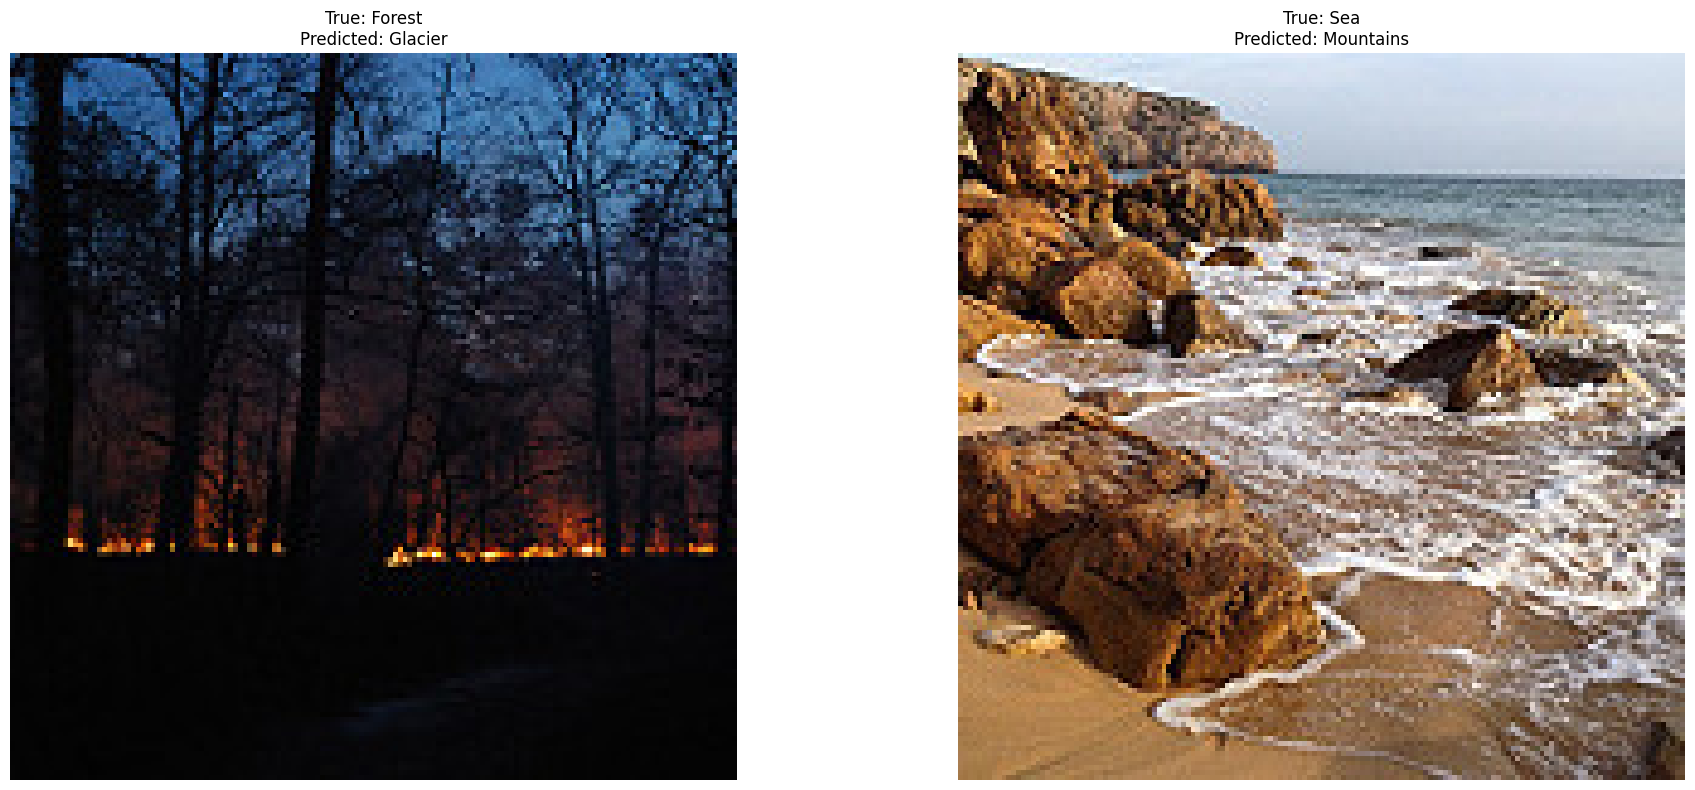

Best model: SVM with F1 Score: 0.5000


In [ ]:
##---------Type the code below this line------------------##


# Plot random test images with their predicted and actual labels
print("\nPlotting test images with predicted and actual labels...")

# Adjust the number of random images to plot based on the size of the test set
num_images_to_plot = min(5, len(test_labels))
random_indices = np.random.choice(len(test_labels), num_images_to_plot, replace=False)

fig, axes = plt.subplots(1, num_images_to_plot, figsize=(20, 8))

for i, idx in enumerate(random_indices):
    image_path = test_df.iloc[idx]["img_name"]
    true_label = test_df.iloc[idx]["label"]
    predicted_label = best_predictions[idx]

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for plotting

    axes[i].imshow(image)
    axes[i].axis('off')
    axes[i].set_title(f"True: {true_label}\nPredicted: {predicted_label}")

plt.tight_layout()
plt.show()

print(f"Best model: {best_features} with F1 Score: {best_score:.4f}")

Justify your choice/inution of feature selection based on the performance of model such that why a particualr set have features might have performed well.


In [ ]:
##---------Type the answers below this line------------------##

# 6. Documentation, Study presentation and Code Quality -- Score: 1.5 Marks

### NOTE


All Late Submissions will incur a <b>penalty of -2 marks </b>. So submit your assignments on time.

Good Luck